In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 


In [2]:
# Baca dataset
dataset_path = "../archive/data.csv"
dataset = pd.read_csv(dataset_path, delimiter='\t')

In [3]:
# Ekstrak kolom untuk Anxiety (Q2A, Q4A, Q7A, dst) menggunakan DASS keys
ANXIETY_QUESTIONS = [2, 4, 7, 9, 15, 19, 20, 23, 25, 28, 30, 36, 40, 41]
anxiety_columns = ['Q' + str(i) + 'A' for i in ANXIETY_QUESTIONS]

In [4]:
# Ambil hanya kolom yang berkaitan dengan Anxiety
anxiety_data = dataset[anxiety_columns]

# Kurangi 1 dari semua nilai (mengubah skala 1-4 menjadi 0-3)
anxiety_data = anxiety_data.subtract(1)

# Hitung total skor
anxiety_data['Total_Count'] = anxiety_data.sum(axis=1)

In [5]:
anxiety_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39775 entries, 0 to 39774
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Q2A          39775 non-null  int64
 1   Q4A          39775 non-null  int64
 2   Q7A          39775 non-null  int64
 3   Q9A          39775 non-null  int64
 4   Q15A         39775 non-null  int64
 5   Q19A         39775 non-null  int64
 6   Q20A         39775 non-null  int64
 7   Q23A         39775 non-null  int64
 8   Q25A         39775 non-null  int64
 9   Q28A         39775 non-null  int64
 10  Q30A         39775 non-null  int64
 11  Q36A         39775 non-null  int64
 12  Q40A         39775 non-null  int64
 13  Q41A         39775 non-null  int64
 14  Total_Count  39775 non-null  int64
dtypes: int64(15)
memory usage: 4.6 MB


In [6]:
anxiety_data.duplicated().value_counts()

False    33281
True      6494
Name: count, dtype: int64

In [7]:
anxiety_data.nunique()

Q2A             4
Q4A             4
Q7A             4
Q9A             4
Q15A            4
Q19A            4
Q20A            4
Q23A            4
Q25A            4
Q28A            4
Q30A            4
Q36A            4
Q40A            4
Q41A            4
Total_Count    43
dtype: int64

In [8]:
columns  = anxiety_data.columns

for column in columns:
    print(column)

Q2A
Q4A
Q7A
Q9A
Q15A
Q19A
Q20A
Q23A
Q25A
Q28A
Q30A
Q36A
Q40A
Q41A
Total_Count


In [9]:
# Fungsi untuk menentukan label tingkat kecemasan
def get_anxiety_level(score):
    if score <= 7:
        return 'Normal'
    elif score <= 14:
        return 'Moderate'
    elif score <= 19:
        return 'Severe'
    else:
        return 'Extremely Severe'

In [10]:
# Tambahkan kolom label
anxiety_data['Label'] = anxiety_data['Total_Count'].apply(get_anxiety_level)

# Hapus kolom Total_Count karena sudah tidak diperlukan
final_anxiety_data = anxiety_data.drop(columns=['Total_Count'])

In [11]:
# Visualisasi distribusi label
plt.figure(figsize=(10, 6))
desired_labels = ['Extremely Severe', 'Severe', 'Moderate', 'Normal']
label_counts = final_anxiety_data['Label'].value_counts()

<Figure size 1000x600 with 0 Axes>

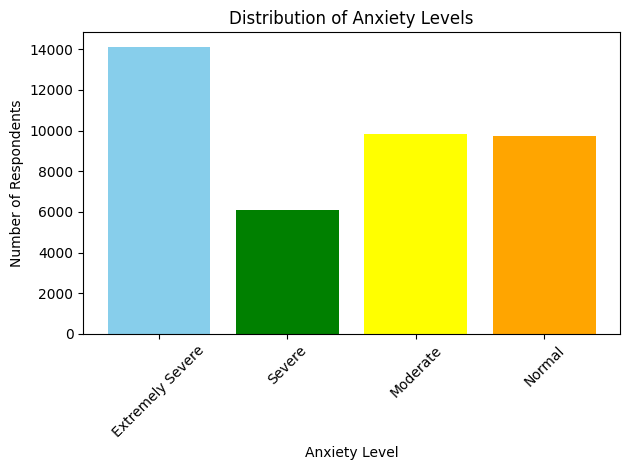

In [12]:
# Plot diagram batang
colors = ['skyblue', 'green', 'yellow', 'orange', 'gray']
label_counts_ordered = label_counts.reindex(desired_labels)
plt.bar(label_counts_ordered.index, label_counts_ordered.values, color=colors)

plt.xlabel('Anxiety Level')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Anxiety Levels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Tampilan beberapa statistik dasar
print("\nDistribusi Label Anxiety:")
print(label_counts_ordered)
print("\nInformasi Dataset:")
print(final_anxiety_data.info())


Distribusi Label Anxiety:
Label
Extremely Severe    14122
Severe               6113
Moderate             9812
Normal               9728
Name: count, dtype: int64

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39775 entries, 0 to 39774
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q2A     39775 non-null  int64 
 1   Q4A     39775 non-null  int64 
 2   Q7A     39775 non-null  int64 
 3   Q9A     39775 non-null  int64 
 4   Q15A    39775 non-null  int64 
 5   Q19A    39775 non-null  int64 
 6   Q20A    39775 non-null  int64 
 7   Q23A    39775 non-null  int64 
 8   Q25A    39775 non-null  int64 
 9   Q28A    39775 non-null  int64 
 10  Q30A    39775 non-null  int64 
 11  Q36A    39775 non-null  int64 
 12  Q40A    39775 non-null  int64 
 13  Q41A    39775 non-null  int64 
 14  Label   39775 non-null  object
dtypes: int64(14), object(1)
memory usage: 4.6+ MB
None


In [14]:
# 1. Encoding label kategori menjadi numerik
label_encoder = LabelEncoder()
final_anxiety_data['Label_Encoded'] = label_encoder.fit_transform(final_anxiety_data['Label'])

In [15]:
# 2. Memisahkan features (X) dan target (y)
X = final_anxiety_data.drop(['Label', 'Label_Encoded'], axis=1)  # Features (jawaban kuesioner)
y = final_anxiety_data['Label_Encoded']  # Target (label yang sudah diencode)

In [16]:
# 3. Normalisasi fitur menggunakan StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [17]:
# 4. Membagi data menjadi training dan testing set (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [18]:
# 5. informasi pembagian dataset
print("Ukuran dataset:")
print(f"Total dataset: {len(final_anxiety_data)}")
print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")

Ukuran dataset:
Total dataset: 39775
Training set: 31820 samples
Testing set: 7955 samples


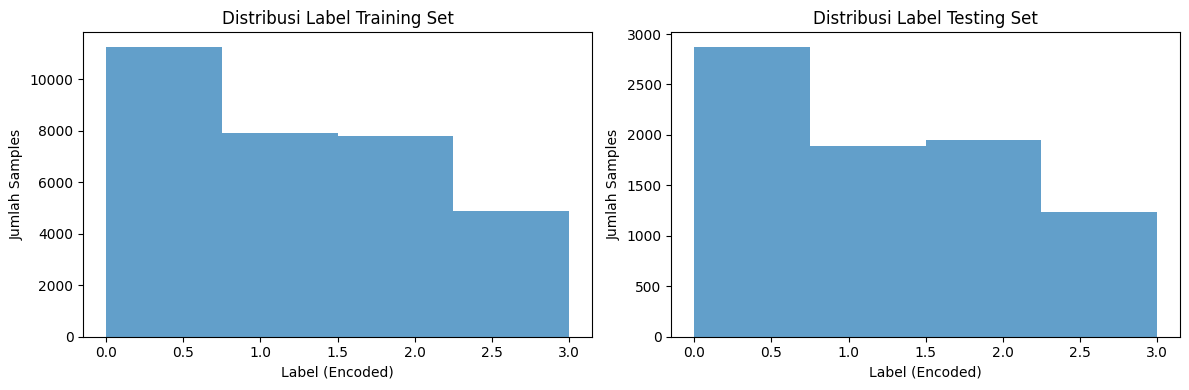

In [19]:
# 6. Visualisasi distribusi
plt.figure(figsize=(12, 4))

# Plot untuk training set
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=len(label_encoder.classes_), alpha=0.7)
plt.title('Distribusi Label Training Set')
plt.xlabel('Label (Encoded)')
plt.ylabel('Jumlah Samples')

# Plot untuk testing set
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=len(label_encoder.classes_), alpha=0.7)
plt.title('Distribusi Label Testing Set')
plt.xlabel('Label (Encoded)')
plt.ylabel('Jumlah Samples')

plt.tight_layout()
plt.show()

In [20]:
# 7. Mencari nilai k optimal
k_range = range(1, 31, 2)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

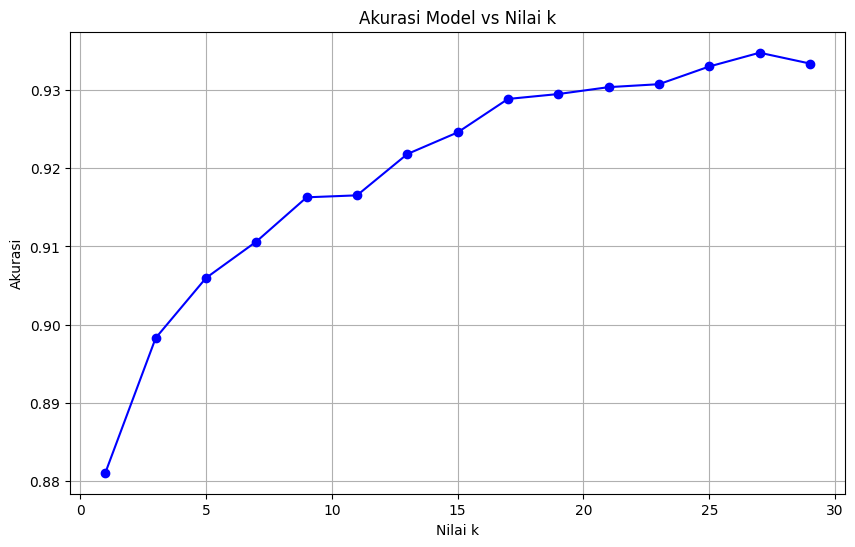

In [21]:
# Plot akurasi vs nilai k
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, 'bo-')
plt.xlabel('Nilai k')
plt.ylabel('Akurasi')
plt.title('Akurasi Model vs Nilai k')
plt.grid(True)
plt.show()

In [22]:
# Mendapatkan nilai k optimal
optimal_k = k_range[scores.index(max(scores))]
print(f"\nNilai k optimal: {optimal_k}")


Nilai k optimal: 27


In [23]:
# Inisialisasi model KNN dengan k optimal
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)

# Training model
knn_model.fit(X_train, y_train)

# Prediksi
y_pred = knn_model.predict(X_test)

In [24]:
# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")


Accuracy: 0.9348


In [25]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
                  precision    recall  f1-score   support

Extremely Severe       0.98      0.98      0.98      2873
        Moderate       0.90      0.89      0.89      1889
          Normal       0.91      1.00      0.95      1952
          Severe       0.92      0.81      0.86      1241

        accuracy                           0.93      7955
       macro avg       0.93      0.92      0.92      7955
    weighted avg       0.94      0.93      0.93      7955



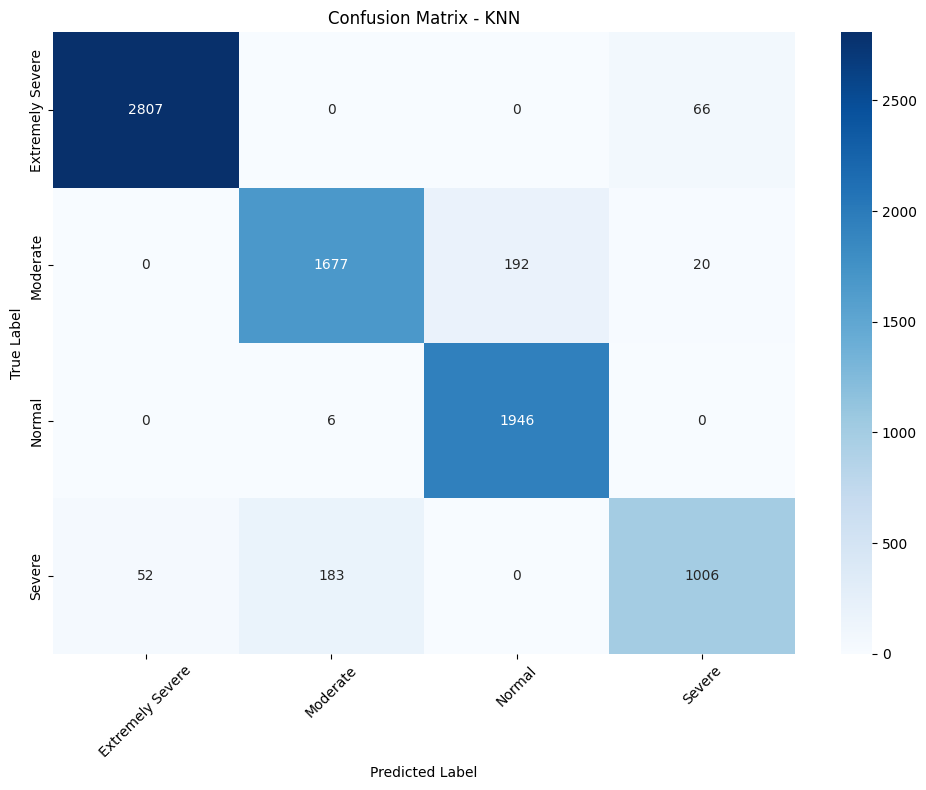

In [26]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - KNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Simpan model
import pickle
with open('knn_anxiety_model.pkl', 'wb') as file:
    pickle.dump(knn_model, file)

# Simpan label encoder dan scaler
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)